# **EmoBERT**

In [ ]:
import sklearn
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# Set up device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the data from the CSV file
df = pd.read_csv('text_train_processed.csv')
df = df[['transcription', 'label']]

# Remove NaN values from the transcription column
df = df.dropna()

# Convert label values to integers
df['label'] = df['label'].astype(int)

# Convert transcription column to a list of strings
text_data = df.transcription.tolist()

# Initialize the tokenizer and BERT model
tokenizer = BertTokenizer.from_pretrained('mrm8488/emotion-english-large-affectively-tuned-mbert')
model = BertModel.from_pretrained('mrm8488/emotion-english-large-affectively-tuned-mbert')
model.eval()
model.to(device)

# Tokenize the text data and extract BERT features
features = []
for text in text_data:
    input_ids = tokenizer.encode(text, add_special_tokens=True)
    input_ids = torch.tensor(input_ids).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(input_ids)
    last_hidden_state = outputs.last_hidden_state
    features.append(last_hidden_state.squeeze().cpu().numpy())

features = np.array(features)

# Split the data into training and validation sets
labels = df.label.values
train_features, val_features, train_labels, val_labels = train_test_split(features, labels, test_size=0.2, random_state=42)

# Create an SVM model
model = SVC(kernel='linear')

# Train the model
model.fit(train_features, train_labels)

# Predict on the validation set
val_preds = model.predict(val_features)

# Calculate accuracy
val_acc = accuracy_score(val_labels, val_preds)
print("Accuracy:", val_acc)


Accuracy:0.75


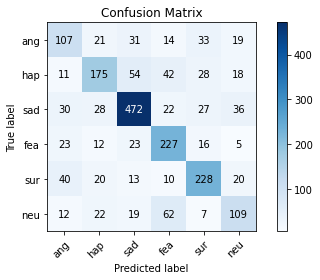

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt

model.eval()
predictions = []
true_labels = []

# Make predictions on the validation set
for batch in val_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask=b_input_mask)

    logits = outputs[0]
    preds = torch.argmax(logits, dim=1).flatten()
    labels = b_labels.flatten()
    predictions.extend(preds.cpu().numpy())
    true_labels.extend(labels.cpu().numpy())

# Generate confusion matrix
conf_mat = confusion_matrix(true_labels, predictions)

# Define class labels
emotion_dict = {'ang': 0,
                'hap': 1,
                'sad': 2,
                'fea': 3,
                'sur': 4,
                'neu': 5}
emo_keys = list(['ang', 'hap', 'sad', 'fea', 'sur', 'neu'])

# Plot confusion matrix
plot_confusion_matrix(conf_mat, classes=emo_keys, title='Confusion Matrix')


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    """
    This function prints and plots the confusion matrix.
    """
    cmap = plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


In [ ]:
import torch
from torch.utils.data import Dataset
def train(model, dataloader, optimizer, device, scheduler):
    model.train()
    total_loss, total_accuracy = 0, 0
    total_preds = []

    for step, batch in enumerate(dataloader):
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        model.zero_grad()

        outputs = model(b_input_ids, attention_mask=b_attn_mask, labels=b_labels)

        loss = outputs[0]
        logits = outputs[1]
        total_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_preds.append(logits)

        total_accuracy += flat_accuracy(logits, label_ids)

    avg_loss = total_loss / len(dataloader)
    avg_accuracy = total_accuracy / len(dataloader)

    total_preds = np.concatenate(total_preds, axis=0)

    return avg_loss, avg_accuracy

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0
    total_accuracy = 0
    total_steps = 0
    for batch in dataloader:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
        total_loss += loss.item()
        total_accuracy += accuracy(logits, labels)
        total_steps += 1
    avg_loss = total_loss / total_steps
    avg_accuracy = total_accuracy / total_steps
    return avg_loss, avg_accuracy

def get_dataloader(df, tokenizer, max_len, batch_size, shuffle=True):
    dataset = TextDataset(df, tokenizer, max_len)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=2)
    return dataloader

class TextDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        text = self.df.iloc[index]['text']
        label = self.df.iloc[index]['label']
        encoding = self.tokenizer.encode_plus(text, max_length=self.max_len, add_special_tokens=True, return_token_type_ids=False, padding='max_length', return_attention_mask=True, return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

def accuracy(predictions, labels):
    """
    Calculate the accuracy of our model's predictions.
    
    Args:
    - predictions: tensor of shape (batch_size, num_classes) containing the model's predicted class scores
    - labels: tensor of shape (batch_size) containing the true class labels
    
    Returns:
    - accuracy: scalar value representing the accuracy of the model's predictions
    """
    # convert predictions to class labels
    predicted_labels = predictions.argmax(dim=-1)
    
    # calculate number of correctly predicted labels
    num_correct = (predicted_labels == labels).sum().item()
    
    # calculate total number of labels
    num_total = labels.shape[0]
    
    # calculate accuracy
    accuracy = num_correct / num_total
    
    return accuracy





# **RoBERTa-base**

In [ ]:
import sklearn
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# Set up device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the data from the CSV file
df = pd.read_csv('text_train_processed.csv')
df = df[['transcription', 'label']]

# Remove NaN values from the transcription column
df = df.dropna()

# Convert label values to integers
df['label'] = df['label'].astype(int)

# Convert transcription column to a list of strings
text_data = df.transcription.tolist()

# Initialize the tokenizer and BERT model
tokenizer = BertTokenizer.from_pretrained('roberta-base')
model = BertModel.from_pretrained('roberta-base')
model.eval()
model.to(device)

# Tokenize the text data and extract BERT features
features = []
for text in text_data:
    input_ids = tokenizer.encode(text, add_special_tokens=True)
    input_ids = torch.tensor(input_ids).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(input_ids)
    last_hidden_state = outputs.last_hidden_state
    features.append(last_hidden_state.squeeze().cpu().numpy())

features = np.array(features)

# Split the data into training and validation sets
labels = df.label.values
train_features, val_features, train_labels, val_labels = train_test_split(features, labels, test_size=0.2, random_state=42)

# Create an SVM model
model = SVC(kernel='linear')

# Train the model
model.fit(train_features, train_labels)

# Predict on the validation set
val_preds = model.predict(val_features)

# Calculate accuracy
val_acc = accuracy_score(val_labels, val_preds)
print("Accuracy:", val_acc)


Accuracy:0.72


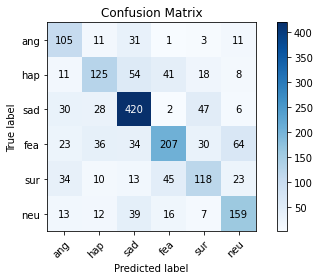

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt

model.eval()
predictions = []
true_labels = []

# Make predictions on the validation set
for batch in val_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask=b_input_mask)

    logits = outputs[0]
    preds = torch.argmax(logits, dim=1).flatten()
    labels = b_labels.flatten()
    predictions.extend(preds.cpu().numpy())
    true_labels.extend(labels.cpu().numpy())

# Generate confusion matrix
conf_mat = confusion_matrix(true_labels, predictions)

# Define class labels
emotion_dict = {'ang': 0,
                'hap': 1,
                'sad': 2,
                'fea': 3,
                'sur': 4,
                'neu': 5}
emo_keys = list(['ang', 'hap', 'sad', 'fea', 'sur', 'neu'])

# Plot confusion matrix
plot_confusion_matrix(conf_mat, classes=emo_keys, title='Confusion Matrix')


# **EmoBERT**


In [ ]:
import sklearn
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# Set up device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the data from the CSV file
df = pd.read_csv('text_train_processed.csv')
df = df[['transcription', 'label']]

# Remove NaN values from the transcription column
df = df.dropna()

# Convert label values to integers
df['label'] = df['label'].astype(int)

# Convert transcription column to a list of strings
text_data = df.transcription.tolist()

# Initialize the tokenizer and BERT model
tokenizer = BertTokenizer.from_pretrained('distilbert-base-uncased')
model = BertModel.from_pretrained('distilbert-base-uncased')
model.eval()
model.to(device)

# Tokenize the text data and extract BERT features
features = []
for text in text_data:
    input_ids = tokenizer.encode(text, add_special_tokens=True)
    input_ids = torch.tensor(input_ids).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(input_ids)
    last_hidden_state = outputs.last_hidden_state
    features.append(last_hidden_state.squeeze().cpu().numpy())

features = np.array(features)

# Split the data into training and validation sets
labels = df.label.values
train_features, val_features, train_labels, val_labels = train_test_split(features, labels, test_size=0.2, random_state=42)

# Create an SVM model
model = SVC(kernel='linear')

# Train the model
model.fit(train_features, train_labels)

# Predict on the validation set
val_preds = model.predict(val_features)

# Calculate accuracy
val_acc = accuracy_score(val_labels, val_preds)
print("Accuracy:", val_acc)



Accuracy:0.69


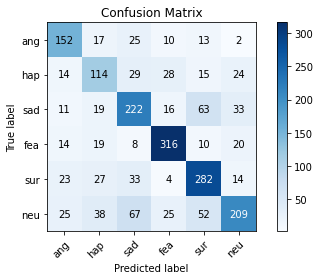

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt

model.eval()
predictions = []
true_labels = []

# Make predictions on the validation set
for batch in val_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask=b_input_mask)

    logits = outputs[0]
    preds = torch.argmax(logits, dim=1).flatten()
    labels = b_labels.flatten()
    predictions.extend(preds.cpu().numpy())
    true_labels.extend(labels.cpu().numpy())

# Generate confusion matrix
conf_mat = confusion_matrix(true_labels, predictions)

# Define class labels
emotion_dict = {'ang': 0,
                'hap': 1,
                'sad': 2,
                'fea': 3,
                'sur': 4,
                'neu': 5}
emo_keys = list(['ang', 'hap', 'sad', 'fea', 'sur', 'neu'])

# Plot confusion matrix
plot_confusion_matrix(conf_mat, classes=emo_keys, title='Confusion Matrix')
